## Video Scene Detection based on Optimal Sequential Grouping

In [106]:
import time
from typing import Tuple, List
from multiprocessing import Pool
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from tqdm import tqdm

import cv2
print(cv2.__version__)
from scipy.spatial import distance
from sklearn import preprocessing
import subprocess

from h_add import get_optimal_sequence_add
from h_nrm import get_optimal_sequence_nrm
from estimate_scenes_count import estimate_scenes_count
from evaluation import calculate_interval_metric

%matplotlib inline

4.2.0


In [107]:
class data_linewidth_plot():
    """
    Draws lines that could scale along with figure size
    Source: https://stackoverflow.com/questions/19394505/matplotlib-expand-the-line-with-specified-width-in-data-unit/42972469#42972469
    """
    def __init__(self, x, y, **kwargs):
        self.ax = kwargs.pop("ax", plt.gca())
        self.fig = self.ax.get_figure()
        self.lw_data = kwargs.pop("linewidth", 1)
        self.lw = 1
        self.fig.canvas.draw()

        self.ppd = 72./self.fig.dpi
        self.trans = self.ax.transData.transform
        self.linehandle, = self.ax.plot([],[],**kwargs)
        if "label" in kwargs: kwargs.pop("label")
        self.line, = self.ax.plot(x, y, **kwargs)
        self.line.set_color(self.linehandle.get_color())
        self._resize()
        self.cid = self.fig.canvas.mpl_connect('draw_event', self._resize)

    def _resize(self, event=None):
        lw =  ((self.trans((1, self.lw_data))-self.trans((0, 0)))*self.ppd)[1]
        if lw != self.lw:
            self.line.set_linewidth(lw)
            self.lw = lw
            self._redraw_later()
            

    def _redraw_later(self):
        self.timer = self.fig.canvas.new_timer(interval=10)
        self.timer.single_shot = True
        self.timer.add_callback(lambda : self.fig.canvas.draw_idle())
        self.timer.start()

        
def plot_distances_chart(distances: np.ndarray, scene_borders: np.ndarray, ax: matplotlib.axes.Axes) -> None:
    """
    Plot scene borders on top of the pairwise distances matrix

    :param distances: pairwise distances matrix
    :param scene_borders:
    """
    ax.imshow(distances, cmap='gray')
    borders_from_zero = np.concatenate(([0], scene_borders))
    for i in range(1, len(borders_from_zero)):    
        data_linewidth_plot(
            x=[borders_from_zero[i-1], borders_from_zero[i-1]],
            y=[borders_from_zero[i-1], borders_from_zero[i]],
            ax=ax, linewidth=1,
            color='red',
            alpha=0.5
        )
        data_linewidth_plot(
            x=[borders_from_zero[i-1], borders_from_zero[i]],
            y=[borders_from_zero[i-1], borders_from_zero[i-1]],
            ax=ax, linewidth=1,
            color='red',
            alpha=0.5
        )
        data_linewidth_plot(
            x=[borders_from_zero[i-1], borders_from_zero[i]],
            y=[borders_from_zero[i], borders_from_zero[i]],
            ax=ax,
            linewidth=1,
            color='red',
            alpha=0.5
        )
        data_linewidth_plot(
            x=[borders_from_zero[i], borders_from_zero[i]],
            y=[borders_from_zero[i-1], borders_from_zero[i]],
            ax=ax,
            linewidth=1,
            color='red',
            alpha=0.5
        )

def get_intervals_from_borders(borders: np.ndarray) -> List[List[Tuple[int, int]]]:
    """
    Convert scene borders to intervals
    
    :param borders: list of borders
    :return: list of interval tuples where first value - beginning of an interval, the second - end of an interval
    """
    intervals = []
    prev_border = 0
    for cur_border in borders:
        intervals.append((prev_border, cur_border))
        prev_border = cur_border
    return intervals

In [108]:
def get_synth_example(
    features_count: int,
    scenes_count: int,
    random_seed: int = 42
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Generates synthetic pairwise distance matrix for features_count shots and scenes_count scenes
    
    :param features_count: count of shots
    :param scenes_count: count of diagonal clusters represented scenes
    :param random_seed: value for random numbers generator initialization
    :return: pairwise distance matrix and scene borders
    """
    synth_distances = np.random.uniform(size=(features_count, features_count))
    np.random.seed(random_seed)
    random_t = np.random.choice(range(2, features_count - 1), size=scenes_count-1, replace=False)
    random_t.sort()
    for i, t in enumerate(random_t):
        if i == 0:
            synth_distances[0:t, 0:t] = np.clip(synth_distances[0:t, 0:t] - 0.4, 0., 1.)
        else:
            synth_distances[random_t[i - 1]:t, random_t[i - 1]:t] = \
                np.clip(synth_distances[random_t[i - 1]:t, random_t[i - 1]:t] - 0.4, 0., 1.)
    synth_distances[random_t[-1]:features_count, random_t[-1]:features_count] = \
        np.clip(synth_distances[random_t[-1]:features_count, random_t[-1]:features_count] - 0.4, 0., 1.)
    random_t = np.append(random_t, [features_count])
    synth_distances = (synth_distances + synth_distances.T)/2

    np.fill_diagonal(synth_distances, 0)
    return synth_distances, random_t - 1


## Sampling representative frames from each shot

In [109]:
#uniform sampling, rewrite to extract mid frame directly instead
def uniform_sampling(num_frames,num_shots):
    for ind in range(1,num_shots):
        shot = os.path.join(data_path, "Honey-final-180k-Scene-{0:03d}.mp4".format(ind))
        vcap = cv2.VideoCapture(shot)
        frame_count = int(vcap.get(cv2.CAP_PROP_FRAME_COUNT))
        fps = vcap.get(cv2.CAP_PROP_FPS)
        vid_name=shot.split("/")[-1][:-4]
        dur=float(frame_count/fps)
        sample_frames= np.linspace(0, dur, num_frames+1)+dur/num_frames/2.
        for i in range(num_frames):
            os.system(' '.join(('ffmpeg', '-loglevel', 'panic', '-ss', str(sample_frames[i]), '-i', shot, os.path.join(sampled_data_path, vid_name+'-'+str(i+1).zfill(2)+'.jpg'))))

def extract_key_frames(num_shots):
    for ind in range(1,num_shots):
        shot = os.path.join(data_path, "Honey-final-180k-Scene-{0:03d}.mp4".format(ind))
        vid_name=shot.split("/")[-1][:-4]
        out = os.path.join(keyframe_data_path, vid_name)
        command = "ffmpeg -loglevel warning -i \"{}\" -q:v 2 -vf select=\"eq(pict_type\,PICT_TYPE_I)\" -vsync 0 {}-%03d.jpg".format(shot,out)
        subprocess.call(command, shell=True) 


data_path ="/Users/raksharamesh/Desktop/DVU_challenge/Dataset/Movies/Honey"
sampled_data_path = os.path.abspath('.')+ "/sampled_frames"
keyframe_data_path = os.path.abspath('.')+ "/keyframe_data_path"
 
num_shots = len([file for file in os.listdir(data_path)])
print(num_shots, "num shots")

if not os.path.isdir(sampled_data_path):
    os.mkdir(os.path.join(sampled_data_path))
    num_frames=10
    uniform_sampling(num_frames,num_shots)

if not os.path.isdir(keyframe_data_path):
    os.mkdir(os.path.join(keyframe_data_path))
    extract_key_frames(num_shots)
    
# for ind in range(1,num_shots):
#     shot = os.path.join(data_path, "Honey-final-180k-Scene-{0:03d}.mp4".format(ind))
#     num_frames = 10
#     uniform_sampling(shot,num_frames)
    

#list of all uniformly sampled frames from shots
img_name_list = []
mid_frame_list = []
for i,img_name in enumerate(sorted(os.listdir(sampled_data_path))):
    img_name_list.append(img_name)
    #append only mid frame
    if img_name[-5]=="5":
        mid_frame_list.append(img_name)
        
#prefix full path 
mid_frame_list = sorted([os.path.join(sampled_data_path,img_name) for img_name in mid_frame_list])
img_name_list = sorted([os.path.join(sampled_data_path, img_name) for img_name in img_name_list])
keyframe_name_list = sorted([os.path.join(keyframe_data_path,img_name) for img_name in os.listdir(keyframe_data_path) if not img_name.startswith('.')])


253 num shots


## Test feature extraction methods

In [110]:
from sklearn import preprocessing
from collections import defaultdict

def compute_feature_dist(np_array):
    distance_np = np.full((252, 252), 0.0)
    for ind1 in range(252):
        for ind2 in range(252):
            distance_np[ind1][ind2] = distance.hamming(np_array[ind1], np_array[ind2])
    #print(distance_np)
    return distance_np
    
#testing out different combinations of features 

#color histograms from only mid-frame of a shot as features
def feature_set1(mid_frame_list):
    np_array = {}
    for ind in range(len(mid_frame_list)):
        vid_name=img_name_list[ind].split("/")[-1][:-4]
        img = cv2.imread(mid_frame_list[ind])
        #hsv = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        #hist = cv2.calcHist([hsv], [0, 1], None, [180,256], [0, 180, 0, 256])
        hist = cv2.calcHist([img], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
        hist = hist.flatten().reshape(-1,1)
        min_max_scaler = preprocessing.MinMaxScaler()
        hist = min_max_scaler.fit_transform(hist)
        np_array[ind] = np.array(hist)
        np_array[ind] = np_array[ind].reshape(-1, 1)
    
    distance_np = compute_feature_dist(np_array)
    return distance_np

#lets average HSV histograms of the keyframes
def feature_set2(keyframe_name_list):
    #print(len(keyframe_name_list))
    #grouping keyframes of shots together
    shot_frames = defaultdict(list)
    for img_path in keyframe_name_list:
        shot_name=img_path.split('-')[-2]
        shot_frames[shot_name].append(img_path)
        
    np_array = {}
    #orb = cv2.ORB_create()
    for shot_name in shot_frames:
        count=1
        #hist_sum = np.zeros((180,256))
        hist_sum = np.zeros((45,64))
        for frame in shot_frames[shot_name]:
                frame = cv2.imread(frame)
                hsv = cv2.cvtColor(frame,cv2.COLOR_RGB2HSV)
                hist = cv2.calcHist([frame], [0, 1, 2], None, [8,8,8],[0, 256, 0, 256, 0, 256])
                hist = cv2.calcHist( [hsv], [0, 1], None, [45, 64], [0, 180, 0, 256] )
                hist_sum += hist
#                 also compute ORB descriptors?
#                 gray= cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
#                 kp = orb.detect(gray,None)
#                 kp, des = orb.compute(gray, kp)
#                 des = des[1,:].reshape(-1,1)
                count +=1    
        hist_avg = hist_sum/count
        min_max_scaler = preprocessing.MinMaxScaler()
        hist_avg = min_max_scaler.fit_transform(hist_avg)
        #print(hist_avg, "hist avg")
        ind = list(shot_frames.keys()).index(shot_name)
        np_array[ind] = np.array(hist_avg.flatten())
        np_array[ind] = np_array[ind].reshape(-1, 1)
        #print(np.shape(np_array[ind]))
    distance_np = compute_feature_dist(np_array)
    return distance_np, shot_frames

#cnn features, using vector from midframe
def feature_set3(mid_frame_list):
    np_array = {}
    for ind in range(0,252):
    #for ind in range(1, 253):
        #shot = "/home/va/research/CYLin/scene/Honey/Honey-final-180k-Scene-{0:03d}.npy".format(ind)
        shot = "/Users/raksharamesh/Desktop/DVU_challenge/code/video-scene-detection/feature/Honey-final-180k-Scene-{0:03d}.npy".format(ind+1)
        np_array[ind] = np.load(shot)
        #shot is sampled at 1FPS, dum: num of frames x 2048
        #print(np.shape(np_array[ind]))
        #np_array[ind] = np.average(np_array[ind], axis=0)
        
        #try mid frame vector instead of averaging
        mid_frame = int(np_array[ind].shape[0]/2)
        np_array[ind] = np_array[ind][mid_frame]
        #print(np_array[ind].shape)
        np_array[ind] = np_array[ind].reshape(-1, 1)
        #print(np_array[ind].shape)
        #print(distance.hamming(np_array[ind], np_array[ind]))
        #print(np_array[ind].shape)
    distance_np = compute_feature_dist(np_array)
    return distance_np



In [113]:
dist1 = feature_set1(mid_frame_list)
dist2, shot_frames = feature_set2(keyframe_name_list)
print(dist1)
#print(np.shape(dist2))
#dist3 = feature_set3(mid_frame_list)

939
[[0.         0.08789062 0.015625   ... 0.015625   0.07421875 0.015625  ]
 [0.08789062 0.         0.08789062 ... 0.08789062 0.0859375  0.08789062]
 [0.015625   0.08789062 0.         ... 0.01367188 0.07421875 0.01367188]
 ...
 [0.015625   0.08789062 0.01367188 ... 0.         0.07421875 0.01367188]
 [0.07421875 0.0859375  0.07421875 ... 0.07421875 0.         0.06835938]
 [0.015625   0.08789062 0.01367188 ... 0.01367188 0.06835938 0.        ]]


In [114]:
#automate scene count estimation 
distance_np = dist2
K = estimate_scenes_count(distance_np)
print(K)

7


Text(0.5, 1, 'Predicted Borders Add')

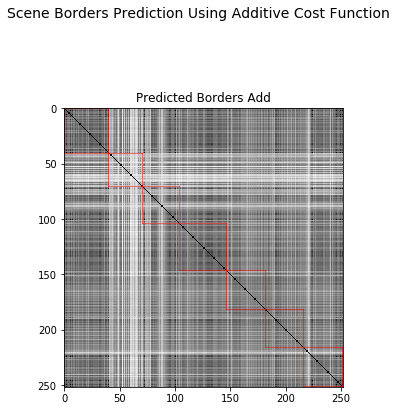

In [115]:
##only use additive cost to evaluate features through plot
scenes_count = K
#scenes_count = 5
optimal_scene_borders_add = get_optimal_sequence_add(distance_np, scenes_count)
figs, axs = plt.subplots(1,1, figsize=(5,7))
figs.suptitle('Scene Borders Prediction Using Additive Cost Function', fontsize=14)
plot_distances_chart(distance_np, optimal_scene_borders_add, axs)
axs.set_title('Predicted Borders Add')

In [116]:
print(optimal_scene_borders_add.shape)
print(optimal_scene_borders_add)

(7,)
[ 40  70 104 146 181 216 251]


Text(0.5, 1, 'Predicted Borders NRM')

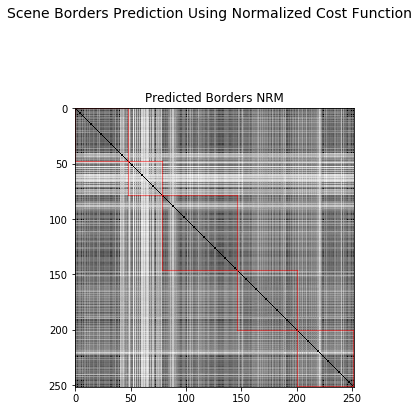

In [117]:
scenes_count = 5
optimal_scene_borders_nrm = get_optimal_sequence_nrm(distance_np, scenes_count)
figs, axs = plt.subplots(1,1, figsize=(5,7))
figs.suptitle('Scene Borders Prediction Using Normalized Cost Function', fontsize=14)
plot_distances_chart(distance_np, optimal_scene_borders_nrm, axs)
axs.set_title('Predicted Borders NRM')

In [118]:
print(optimal_scene_borders_nrm.shape)
print(optimal_scene_borders_nrm)

(5,)
[ 48  78 146 200 251]


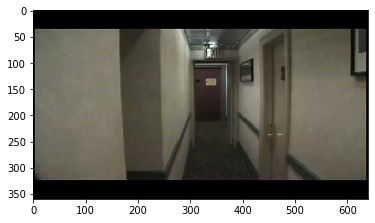

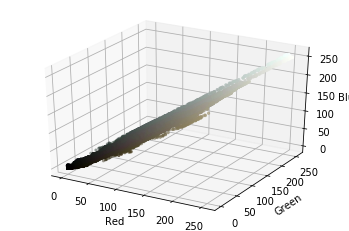

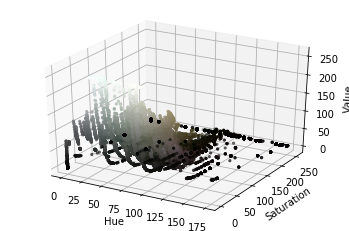

In [64]:

def visualize(img_path):
    
    import matplotlib.pyplot as plt
    import numpy as np
    from mpl_toolkits.mplot3d import Axes3D
    from matplotlib import cm
    from matplotlib import colors

    img = cv2.imread(img_path)
    img_RGB=cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_RGB)
    plt.show()
    
    r, g, b = cv2.split(img_RGB)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    pixel_colors = img_RGB.reshape((np.shape(img_RGB)[0]*np.shape(img_RGB)[1], 3))
    norm = colors.Normalize(vmin=-1.,vmax=1.)
    norm.autoscale(pixel_colors)
    pixel_colors = norm(pixel_colors).tolist()
    axis.scatter(r.flatten(), g.flatten(), b.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue") 
    plt.show()

    img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    h, s, v = cv2.split(img_HSV)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")

    axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel("Hue")
    axis.set_ylabel("Saturation")
    axis.set_zlabel("Value")
    plt.show()


#VISUALIZE RGB & HSV values of key frames of shots
visualize(shot_frames["005"][0])

In [ ]:
# Let's generate random pairwise distances matrix, add some uniform noise and calculate optimal borders accordingly to Additive Cost Function.
shots_count = 100
scenes_count = 10
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count)
print(distances.shape, type(distances))
print(np.sum(distances[0]))
print(np.max(distances[1]))

optimal_scene_borders = get_optimal_sequence_add(distances, scenes_count)
# optimal_scene_borders = get_optimal_sequence_nrm(distances, scenes_count)
figs, axs = plt.subplots(1,1, figsize=(5,7))
figs.suptitle('Scene Borders Prediction Using Additive Cost Function', fontsize=14)
plot_distances_chart(distances, synth_scene_borders, axs)
axs.set_title('Ground Truth Borders')
# plot_distances_chart(distances, optimal_scene_borders, axs[1])
# axs[1].set_title('Predicted Borders')

In [ ]:
shots_count = 100
scenes_count = 10
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count)
optimal_scene_borders = get_optimal_sequence_add(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,7))
figs.suptitle('Scene Borders Prediction Using Additive Cost Function', fontsize=14)
plot_distances_chart(distances, synth_scene_borders, axs[0])
axs[0].set_title('Ground Truth Borders')
plot_distances_chart(distances, optimal_scene_borders, axs[1])
axs[1].set_title('Predicted Borders')

## Normalized Cost Function

Let's generate random pairwise distances matrix, add some uniform noise and calculate optimal borders accordingly to Normalized Cost Function.

In [ ]:
shots_count = 100
scenes_count = 10
distances, synth_scene_borders = get_synth_example(shots_count, scenes_count)
optimal_scene_borders = get_optimal_sequence_nrm(distances, scenes_count)
figs, axs = plt.subplots(1,2, figsize=(15,7))
figs.suptitle('Scene Borders Prediction Using Normalized Cost Function', fontsize=14)
plot_distances_chart(distances, synth_scene_borders, axs[0])
axs[0].set_title('Ground Truth Borders')
plot_distances_chart(distances, optimal_scene_borders, axs[1])
axs[1].set_title('Predicted Borders')

As you can see, Additive Const Function works a little bit worse than Normalized Cost Function. But one example is not enough.

## Quality Tests

Let's generate 999 synthetic examples and check both algorithm's quality on several metrics.

In [ ]:
test_examples = []
for N in range(12, 123):
    for K in range(2,11):
        test_examples.append(get_synth_example(N, K))

Find optimal borders for each example with Hadd optimisation:

In [ ]:
predicted_examples_add = []
def predict_examples_add(args):
    distances, synth_scene_borders = args
    K = estimate_scenes_count(distances)
    return get_optimal_sequence_add(distances, K)

with Pool(4) as pool:
    predicted_examples_add = list(tqdm(pool.imap(predict_examples_add, test_examples), total=len(test_examples)))

Find optimal borders for each example with Hnrm optimisation:

In [ ]:
predicted_examples_nrm = []
def predict_examples_nrm(args):
    distances, synth_scene_borders = args
    K = estimate_scenes_count(distances)
    return get_optimal_sequence_nrm(distances, K)

with Pool(4) as pool:
    predicted_examples_nrm = list(tqdm(pool.imap(predict_examples_nrm, test_examples), total=len(test_examples)))

Convert scene borders to intervals:

In [ ]:
predicted_intervals_add = []
for example in predicted_examples_add:
    predicted_intervals_add.append(get_intervals_from_borders(example))
    
predicted_intervals_nrm = []
for example in predicted_examples_nrm:
    predicted_intervals_nrm.append(get_intervals_from_borders(example))
        
gt_intervals = []
for distances, synth_scene_borders in test_examples:
    gt_intervals.append(get_intervals_from_borders(synth_scene_borders))

Get mean precision, recall, F1 and IoU for each result:

In [ ]:
precision_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'precision')
recall_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'recall')
f1_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'f1')
iou_add = calculate_interval_metric(gt_intervals, predicted_intervals_add, 'iou')

In [ ]:
precision_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'precision')
recall_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'recall')
f1_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'f1')
iou_nrm = calculate_interval_metric(gt_intervals, predicted_intervals_nrm, 'iou')

In [ ]:
print('Precision add: {} Precision nrm: {}'.format(precision_add, precision_nrm))
print('Recall add: {} Recall nrm: {}'.format(recall_add, recall_nrm))
print('F1 add: {} F1 nrm: {}'.format(f1_add, f1_nrm))
print('IoU add: {} IoU nrm: {}'.format(iou_add, iou_nrm))

As we can see, optimisation of the Hnrm metrics works better than Hadd accordingly to each mertics.

## Time Tests

But what about speed?

Let's fix scenes count K, and see, how optimization time depends on shots count N:

In [ ]:
test_data = []
K = 5
Ns = range(10, 100)
for N in Ns:
    test_data.append(get_synth_example(N, K))
ns_add_times = []
ns_nrm_times = []
for distances, synth_scene_borders in test_data:
    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_add(distances, K)
    ns_add_times.append(time.time() - start_time)

    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_nrm(distances, K)
    ns_nrm_times.append(time.time() - start_time)

In [ ]:
plt.figure(figsize=(15,7))
ax = plt.gca()
ax.plot(Ns, ns_add_times, label='H_add optimization time in seconds')
ax.plot(Ns, ns_nrm_times, label='H_nrm optimization time in seconds')
ax.set(title='Dependence of the Optimization Time from Shots Number', ylabel='Time (sec)', xlabel='Number of shots')
ax.legend(loc='best') 

In one more test we'll fix count of shots N, and see how optimization time depends on scenes count K:

In [ ]:
test_data = []
N = 70
Ks = range(2, 12)
for K in Ks:
    test_data.append(get_synth_example(N, K))
ks_add_times = []
ks_nrm_times = []
for distances, synth_scene_borders in test_data:
    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_add(distances, len(synth_scene_borders))
    ks_add_times.append(time.time() - start_time)

    start_time = time.time()
    optimal_scene_borders = get_optimal_sequence_nrm(distances, len(synth_scene_borders))
    ks_nrm_times.append(time.time() - start_time)

In [ ]:
plt.figure(figsize=(15,7))
ax = plt.gca()
ax.plot(Ks, ks_add_times, label='H_add optimization time in seconds')
ax.plot(Ks, ks_nrm_times, label='H_nrm optimization time in seconds')
ax.set(title='Dependence of the Optimization Time from Scenes Number', ylabel='Time (sec)', xlabel='Number of scenes')
ax.legend(loc='best') 

In both experiments we can see, that optimisation process of the Hnrm way more slower than optimisation of the Hadd.

Real world tasks offer much higher values of both N and K, so for now we cannot use Hnrm despite it's higher accuracy.